In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner

In [2]:
A=np.loadtxt("Espectro.dat")

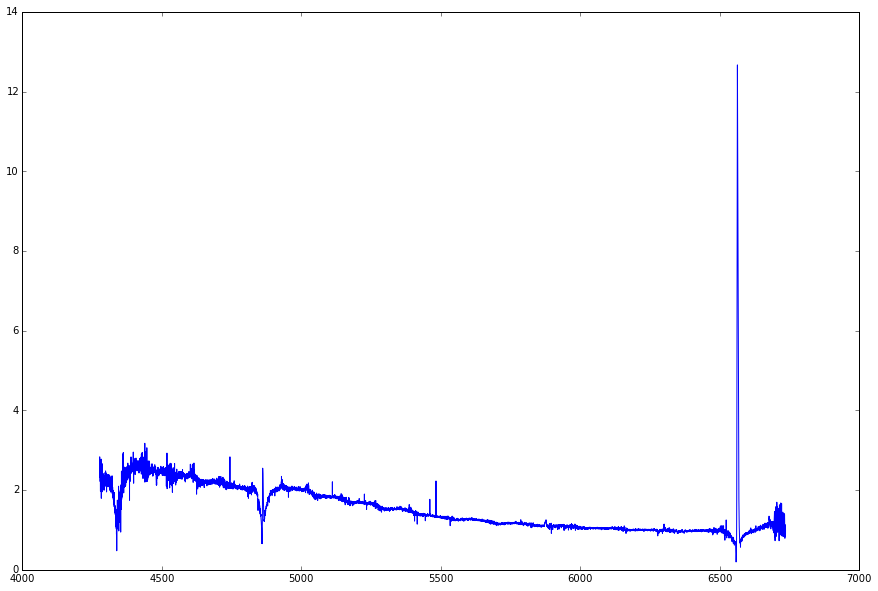

In [3]:
plt.figure(figsize=(15,10))
plt.plot(A[:,0],A[:,1])

In [11]:
def bbody(l,T,A,B):
    l=l/1.e10
    c2=1.439e-2
    A=A*1e-30
    return (A/l**5)*(1/(np.exp(c2/(l*T))-1))+B


In [9]:
import scipy.optimize as op


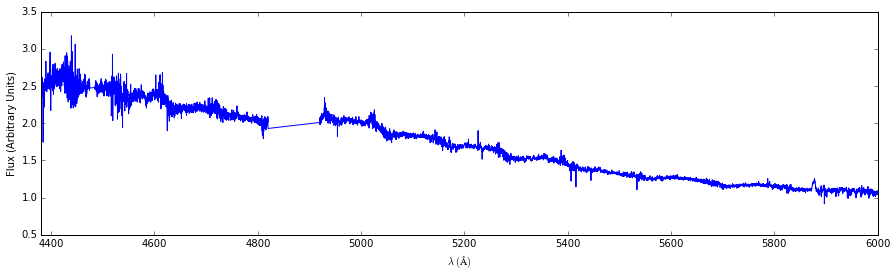

In [277]:
l=A[:,0]
x=A[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]

x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4475
#lwfi=490
lwfi=4485
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4744
#lwfi=490
lwfi=4746
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5111
#lwfi=490
lwfi=5112
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5460
#lwfi=490
lwfi=5462
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5482
#lwfi=490
lwfi=5484
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.figure(figsize=(15,4))
plt.plot(l,x)
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')
y=x
x=l

In [46]:
yerr=1

In [47]:
def lnlike(theta, x, y,yerr):
    x=x/1.e10
    c2=1.439e-2
    T,AA,B = theta
    AA=AA*1e-30
    model = (AA/x**5)*(1./(np.exp(c2/(x*T))-1.))+B
    inv_sigma2 = 1.0/((yerr)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))

9690.45763155 1.64488465668 -0.961056586235


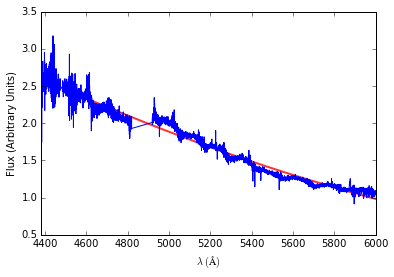

In [278]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [10000, 1,-1], args=(x, y,yerr))
T_ml, A_ml, B_ml= result["x"]
print T_ml, A_ml,B_ml
xl = np.linspace(x.min(), x.max(),1000)
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="r", lw=2, alpha=0.8,label="Bayesian model draws")
plt.plot(x,y)
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')

In [57]:
def lnprior(theta):
    T,AA,B = theta
    if 5000 < T < 15000 and -5 < AA < 5 and -10 < B < 10:
        return 0.0
    return -np.inf
def lnprob(theta, x, y,yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y,yerr)

http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/

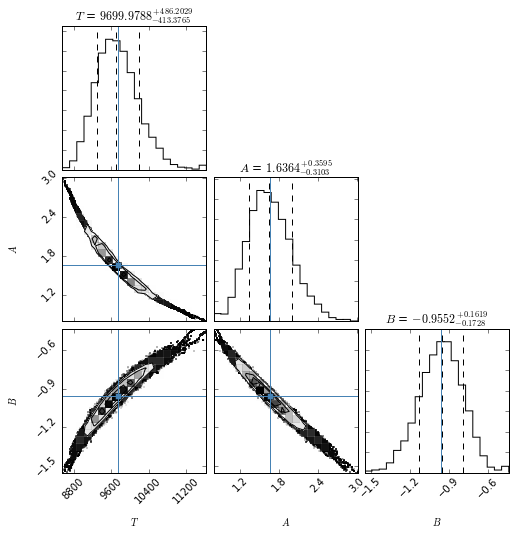

In [59]:
mylab=["$T$", "$A$","$B$"]
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [10000, 1,-1], args=(x, y,yerr))
T_ml, A_ml, B_ml= result["x"]
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y,yerr))
sampler.run_mcmc(pos, 5000);
samplesli = sampler.chain[:, 100:, :].reshape((-1, ndim))
meanestli=samplesli.mean(axis=0)
fig = corner.corner(samplesli, labels=mylab,
                      truths=meanestli, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

In [77]:
meanestli-np.array([T_ml,A_ml,B_ml])

array([  5.03508471e+01,   1.54174222e-02,   7.64384144e-04])

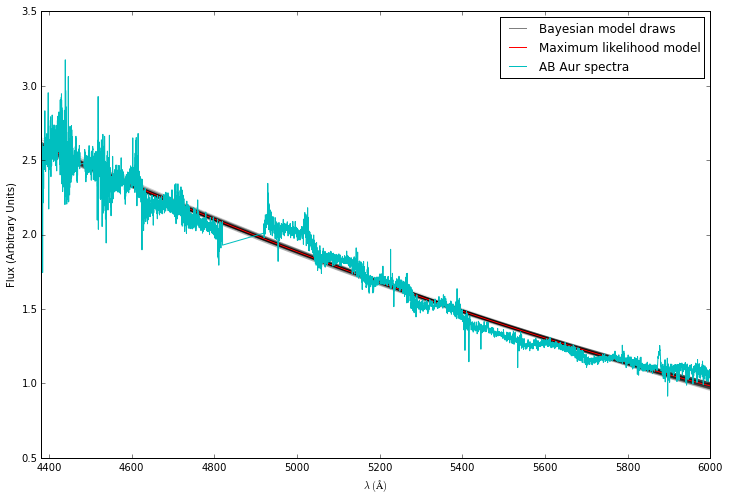

In [283]:
plt.figure(figsize=(12,8))
for t, a,b in samplesli[np.random.randint(len(samplesli), size=100)]:
    plt.plot(xl, bbody(xl, t, a,b), color="k", alpha=0.1)
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="k", alpha=0.5,label="Bayesian model draws")
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="r",label="Maximum likelihood model")
#plt.plot(xl, bbody(xl, meanestli[0], meanestli[1]-0.03,meanestli[2]), color="r", lw=2, alpha=0.8,label="Best (frequentist) model")
plt.plot(x,y,c='c',label="AB Aur spectra")
#AAA=samplesli[np.random.randint(len(samplesli), size=len(x))]
#yy_siml=AAA[:,0]*x+AAA[:,1]
#plt.scatter(x,yy_siml,c='y')
plt.xlim(x.min(),)
plt.legend()
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')

In [103]:
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print autocorr.mean(),autocorr.std()
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['T','A','B',],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

AutocorrError: The chain is too short to reliably estimate the autocorrelation time

In [327]:
A2=np.loadtxt("abaur_full_ORDEN38_2014 abril 10.dat")

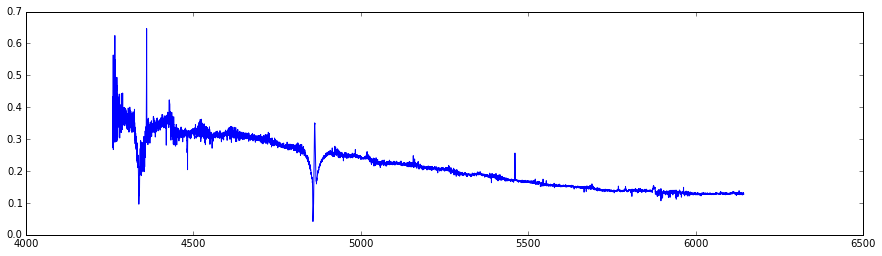

In [328]:
plt.figure(figsize=(15,4))
l=A2[:,0]
x=A2[:,1]
plt.plot(l,x)

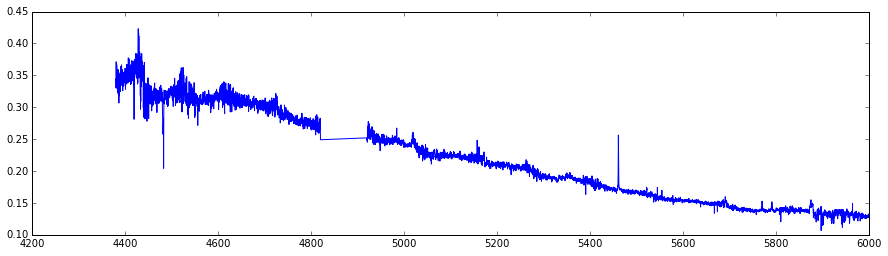

In [329]:
plt.figure(figsize=(15,4))
l=A2[:,0]
x=A2[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.plot(l,x)

In [330]:
y=x
x=l

10000.0003805 0.206591783488 -0.151162484113


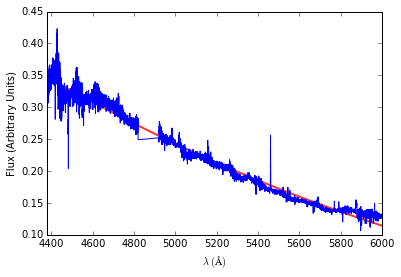

In [331]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [10000, 1,-1], args=(x, y,yerr))
T_ml, A_ml, B_ml= result["x"]
print T_ml, A_ml,B_ml
xl = np.linspace(x.min(), x.max(),1000)
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="r", lw=2, alpha=0.8,label="Bayesian model draws")
plt.plot(x,y)
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')

In [332]:
A2=np.loadtxt("abaur_full_ORDEN38_2014 febrero 26.dat")

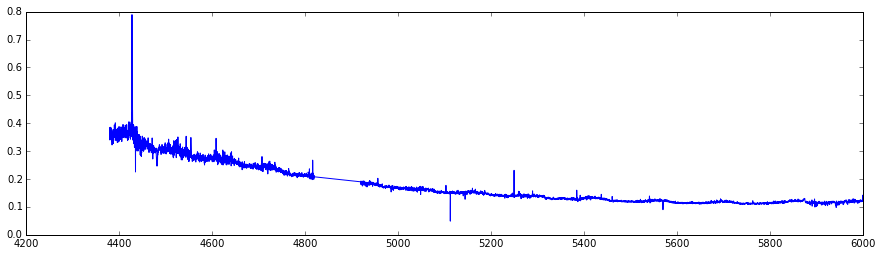

In [333]:
plt.figure(figsize=(15,4))
l=A2[:,0]
x=A2[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.plot(l,x)
y=x
x=l

14896.692089 0.0530125265368 -0.0913450281445


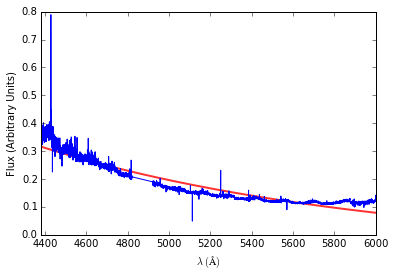

In [334]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [10000, 1,-1], args=(x, y,yerr))
T_ml, A_ml, B_ml= result["x"]
print T_ml, A_ml,B_ml
xl = np.linspace(x.min(), x.max(),1000)
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="r", lw=2, alpha=0.8,label="Bayesian model draws")
plt.plot(x,y)
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')

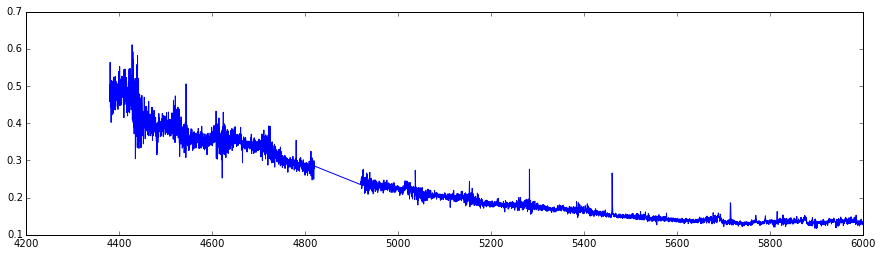

In [335]:
A2=np.loadtxt("abaur_full_ORDEN38_2014 marzo 18.dat")
plt.figure(figsize=(15,4))
l=A2[:,0]
x=A2[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.plot(l,x)
y=x
x=l

17208.0645124 0.0510606032402 -0.125645083261


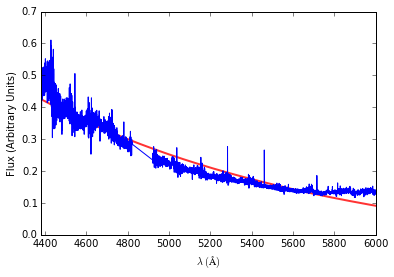

In [336]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [10000, 1,-1], args=(x, y,yerr))
T_ml, A_ml, B_ml= result["x"]
print T_ml, A_ml,B_ml
xl = np.linspace(x.min(), x.max(),1000)
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="r", lw=2, alpha=0.8,label="Bayesian model draws")
plt.plot(x,y)
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')

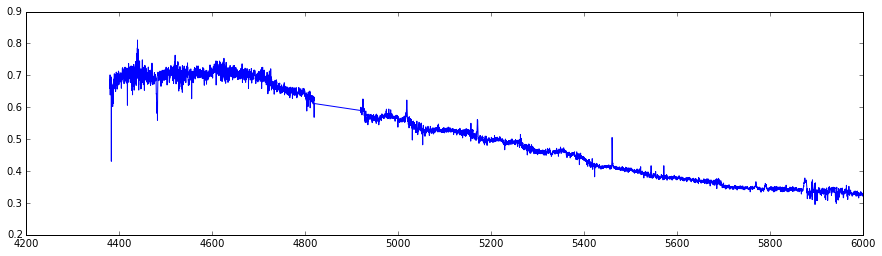

In [337]:
A2=np.loadtxt("abaur_full_ORDEN38_2014 marzo 27.dat")
plt.figure(figsize=(15,4))
l=A2[:,0]
x=A2[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.plot(l,x)
y=x
x=l

9081.78733693 0.625953524932 -0.319903211192


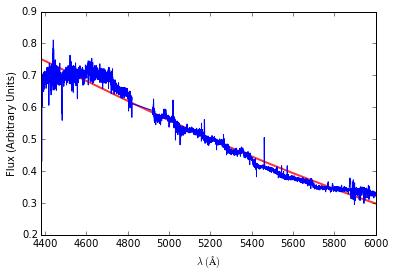

In [338]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [10000, 1,-1], args=(x, y,yerr))
T_ml, A_ml, B_ml= result["x"]
print T_ml, A_ml,B_ml
xl = np.linspace(x.min(), x.max(),1000)
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="r", lw=2, alpha=0.8,label="Bayesian model draws")
plt.plot(x,y)
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')

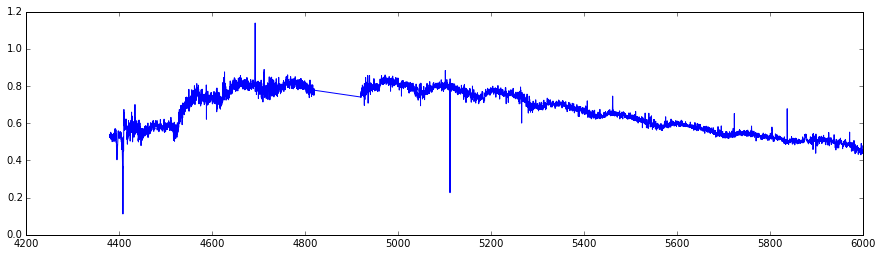

In [339]:
A2=np.loadtxt("abaur_full_ORDEN38_2015 febrero 16.dat")
plt.figure(figsize=(15,4))
l=A2[:,0]
x=A2[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.plot(l,x)
y=x
x=l

5818.40437107 21.9626432435 -4.25305296596


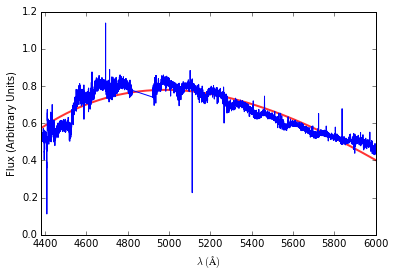

In [340]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [10000, 1,-1], args=(x, y,yerr))
T_ml, A_ml, B_ml= result["x"]
print T_ml, A_ml,B_ml
xl = np.linspace(x.min(), x.max(),1000)
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="r", lw=2, alpha=0.8,label="Bayesian model draws")
plt.plot(x,y)
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')

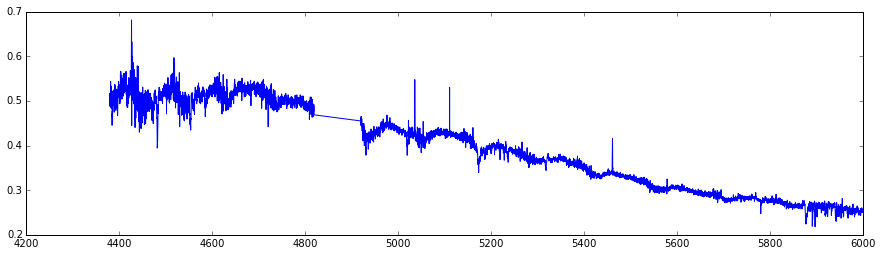

In [341]:
A2=np.loadtxt("abaur_full_ORDEN38_2015 marzo 6.dat")
plt.figure(figsize=(15,4))
l=A2[:,0]
x=A2[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.plot(l,x)
y=x
x=l

7545.08924117 1.22475353182 -0.449957178051


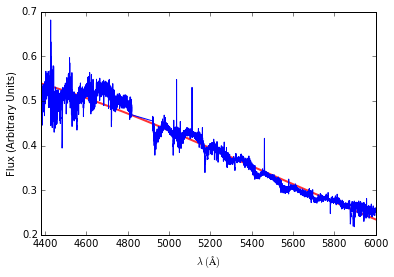

In [342]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [10000, 1,-1], args=(x, y,yerr))
T_ml, A_ml, B_ml= result["x"]
print T_ml, A_ml,B_ml
xl = np.linspace(x.min(), x.max(),1000)
plt.plot(xl, bbody(xl, T_ml, A_ml,B_ml), color="r", lw=2, alpha=0.8,label="Bayesian model draws")
plt.plot(x,y)
plt.xlim(l.min(),l.max())
plt.xlabel(r'$\lambda\ (\AA)$')
plt.ylabel(r'Flux (Arbitrary Units)')

(0.15, 0.2)

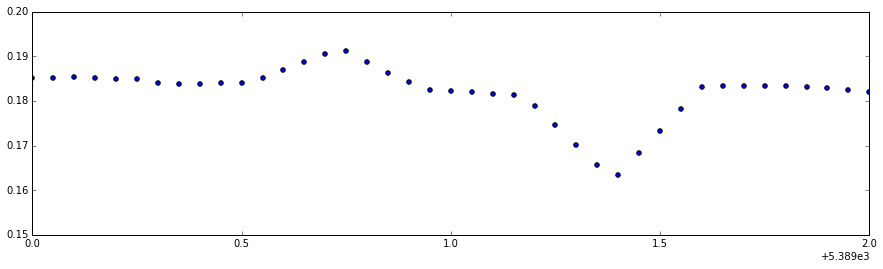

In [246]:
plt.figure(figsize=(15,4))
plt.scatter(l,x)
#plt.plot(l,bbody(l,ptemp.mean(),pA.mean()))
#dd=4482
#lim=1
#dd=5156.5
#lim=1
dd=5389
lim=2
plt.xlim(dd,dd+lim)
plt.ylim(0.15,0.20)

In [227]:
limin=dd
ldel=lim
xint=x[(l>limin)&(l<limin+ldel)]
lint=l[(l>limin)&(l<limin+ldel)]

In [228]:
np.abs(xint-xint.mean())/xint.mean()

array([ 0.0165576 ,  0.00852739,  0.00048631,  0.00754619,  0.01192773,
        0.01494572,  0.01795424,  0.02097316,  0.04777574])

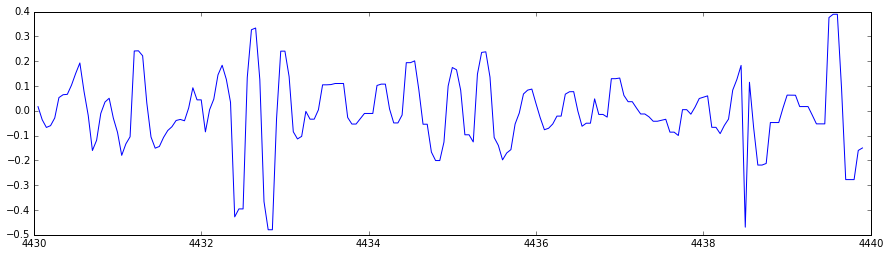

In [199]:
plt.figure(figsize=(15,4))
plt.plot(lint[:-1],(xint[:-1]-xint[1:])/(lint[:-1]-lint[1:]))

In [248]:
xint=x
lint=l

In [249]:
xpri=(xint[:-1]-xint[1:])

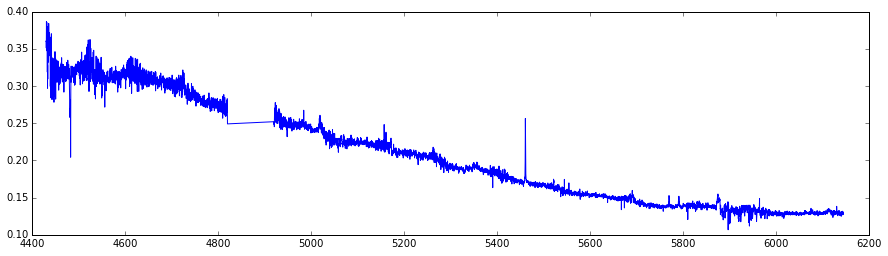

In [255]:
plt.figure(figsize=(15,4))
plt.plot(lint,xint)

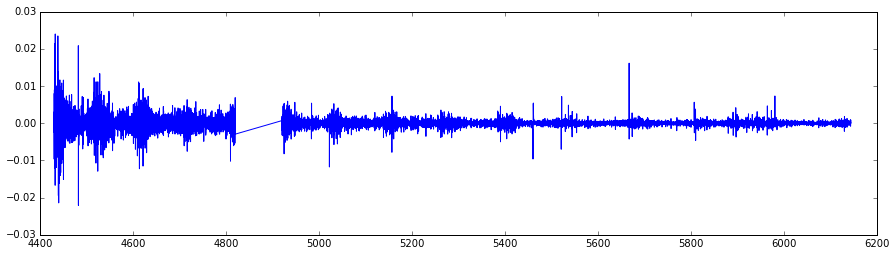

In [250]:
plt.figure(figsize=(15,4))
plt.plot(lint[:-1],xpri)

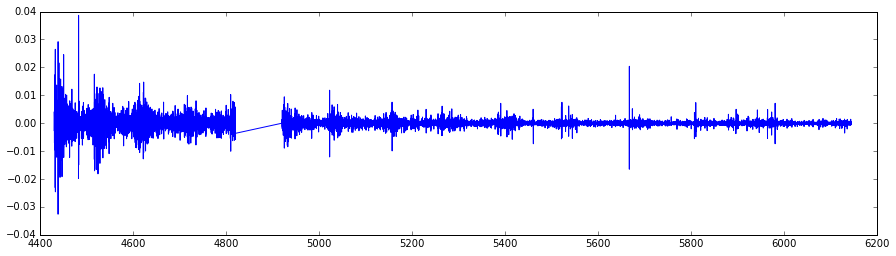

In [251]:
xsec=xpri[:-1]-xpri[1:]
plt.figure(figsize=(15,4))

plt.plot(lint[:-2],xsec)

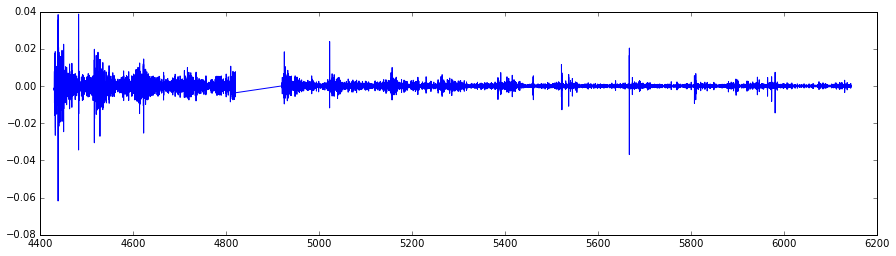

In [252]:
xthi=xsec[:-1]-xsec[1:]
plt.figure(figsize=(15,4))

plt.plot(lint[:-3],xthi)

(0, 0.1)

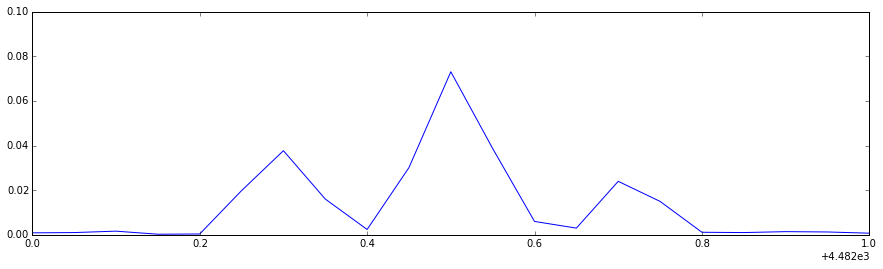

In [272]:
xfou=xthi[:-1]-xthi[1:]
plt.figure(figsize=(15,4))

plt.plot(lint[:-4],np.abs(xfou))
plt.xlim(4482,4483)
plt.ylim(0,0.1)

(0, 0.2)

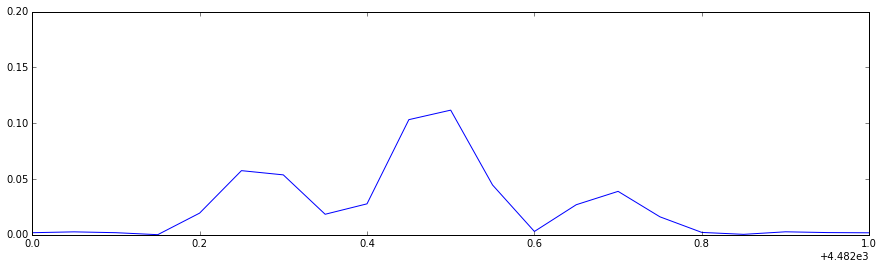

In [266]:
xfif=xfou[:-1]-xfou[1:]
plt.figure(figsize=(15,4))

plt.plot(lint[:-5],np.abs(xfif))
plt.xlim(4482,4483)
plt.ylim(0,0.2)

(0, 0.3)

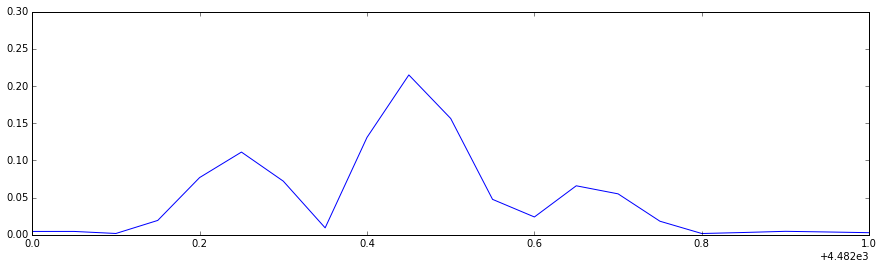

In [271]:
xsix=xfif[:-1]-xfif[1:]
plt.figure(figsize=(15,4))

plt.plot(lint[:-6],np.abs(xsix))
plt.xlim(4482,4483)
plt.ylim(0,0.3)

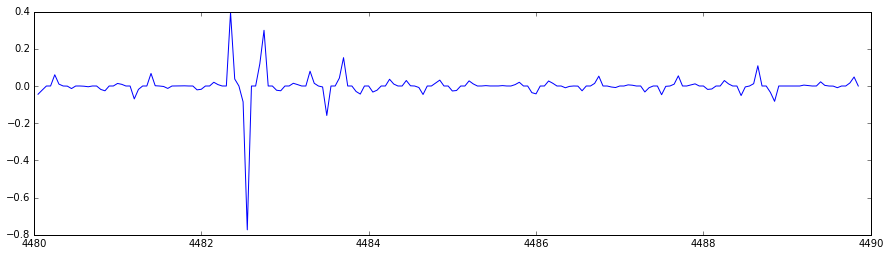

In [181]:
plt.figure(figsize=(15,4))

plt.plot(lint[:-2],xpri[:-1]-xpri[1:])

(5450, 5470)

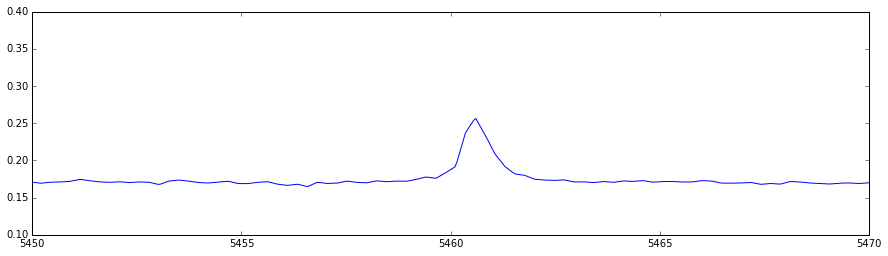

In [182]:
plt.figure(figsize=(15,4))
plt.plot(l,x)
#plt.plot(l,bbody(l,ptemp.mean(),pA.mean()))
dd=5450
lim=20
plt.xlim(dd,dd+lim)

In [183]:
limin=dd
ldel=lim
xint=x[(l>limin)&(l<limin+ldel)]
lint=l[(l>limin)&(l<limin+ldel)]

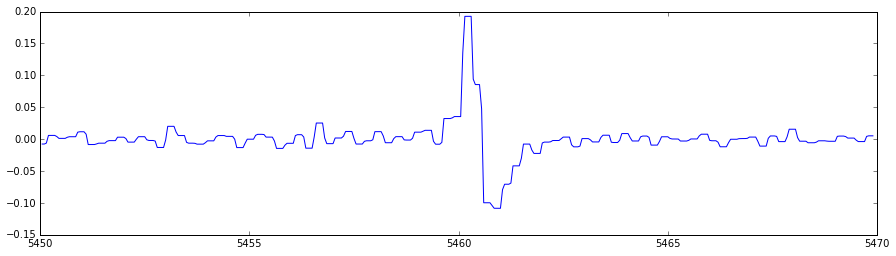

In [184]:
plt.figure(figsize=(15,4))
plt.plot(lint[:-1],(xint[:-1]-xint[1:])/(lint[:-1]-lint[1:]))

In [185]:
xpri=(xint[:-1]-xint[1:])/(lint[:-1]-lint[1:])

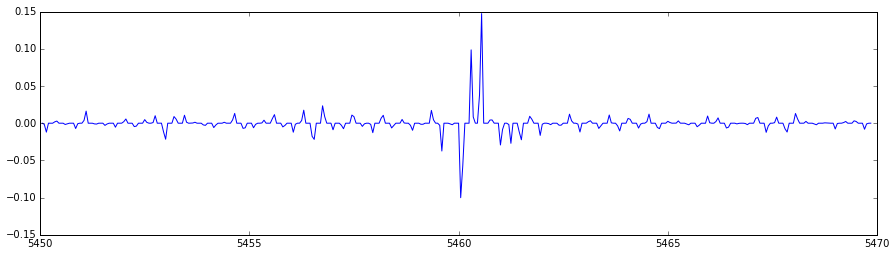

In [186]:
plt.figure(figsize=(15,4))

plt.plot(lint[:-2],xpri[:-1]-xpri[1:])

In [136]:
5150./11111

0.4635046350463505

(4480, 4490)

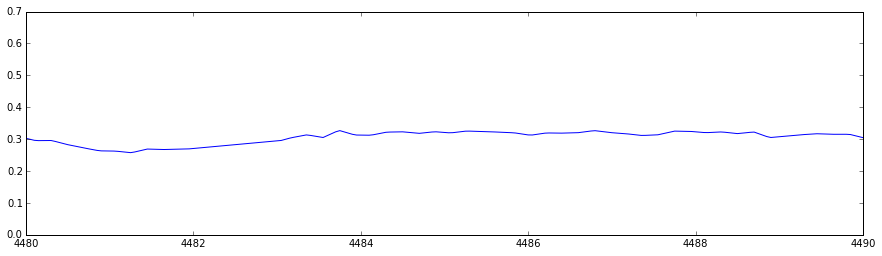

In [121]:
lwin=4482
lwfi=4483
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4482
lwfi=4483
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
plt.figure(figsize=(15,4))
plt.plot(l,x)
#plt.plot(l,bbody(l,ptemp.mean(),pA.mean()))
dd=4480
lim=10
plt.xlim(dd,dd+lim)

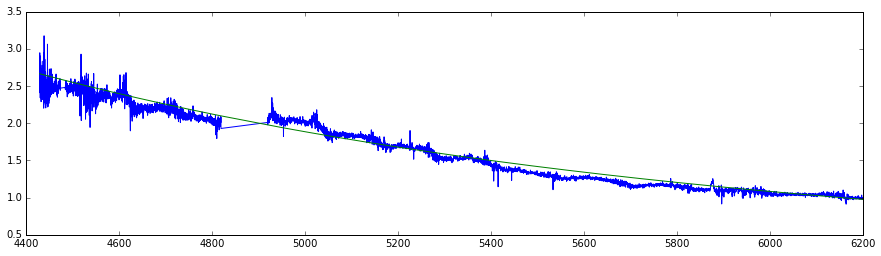

In [311]:
plt.figure(figsize=(15,4))
plt.plot(l,x)
plt.plot(l,bbody(l,ptemp.mean(),pA.mean()))
dd=6200
#plt.xlim(dd,dd+100)

Teff,Aeff,Beff,RErrT,RErrA= 9709.44991383 1.68028516078 -0.97204325775 4.57736918226 19.5841222177


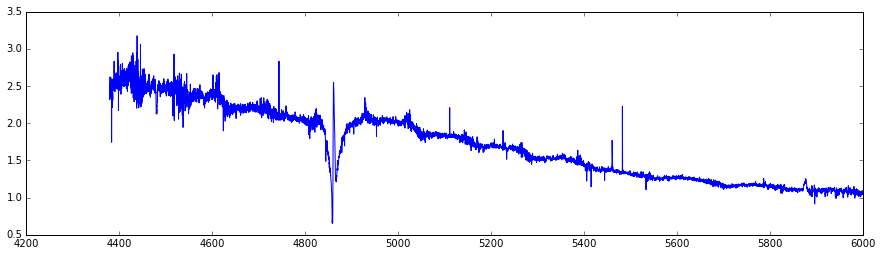

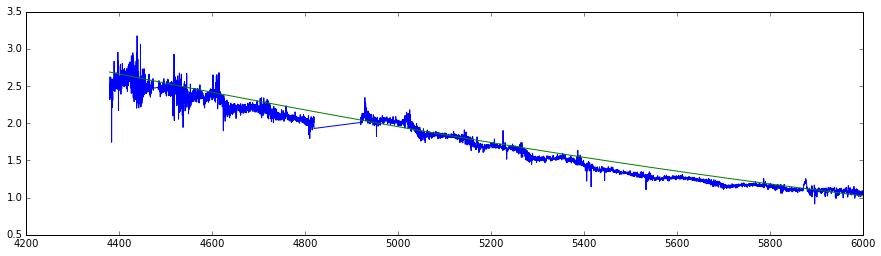

In [8]:
l=A[:,0]
x=A[:,1]
lin=4380
lfi=6000
lwin=4820
#lwfi=4920
lwfi=4920
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
plt.figure(figsize=(15,4))
plt.plot(l,x)
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4475
#lwfi=490
lwfi=4485
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4744
#lwfi=490
lwfi=4746
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5111
#lwfi=490
lwfi=5112
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5460
#lwfi=490
lwfi=5462
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5482
#lwfi=490
lwfi=5484
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))

miter=100000
prob=1/100.
ptemp=np.zeros(miter)
pA=np.zeros(miter)
pB=np.zeros(miter)
for i in range(miter):
    lottery=np.random.choice([0, 1], size=(x.size,), p=[1-prob, prob])
    llot=lottery.astype(bool)
    par,pconv = curve_fit(bbody, l[llot], x[llot],p0=[10000.,1.,1.])
    ptemp[i]=par[0]
    pA[i]=par[1]
    pB[i]=par[2]
plt.figure(figsize=(15,4))
plt.plot(l,x)
plt.plot(l,bbody(l,ptemp.mean(),pA.mean(),pB.mean()))
Teff=ptemp.mean()
Aeff=pA.mean()
Beff=pB.mean()
print "Teff,Aeff,Beff,RErrT,RErrA=",ptemp.mean(),pA.mean(),pB.mean(),np.std(ptemp)*100/np.mean(ptemp),np.std(pA)*100/np.mean(pA)


In [526]:
plt.plot?

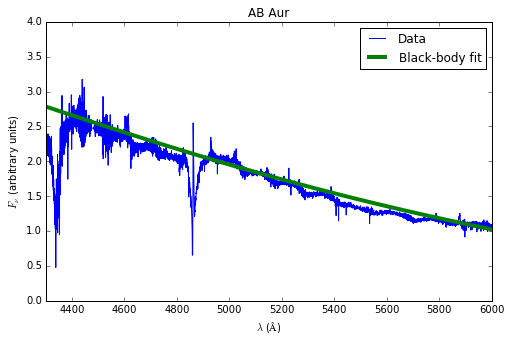

In [550]:
l=A[:,0]
x=A[:,1]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4475
#lwfi=490
lwfi=4485
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4744
#lwfi=490
lwfi=4746
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5111
#lwfi=490
lwfi=5112
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5460
#lwfi=490
lwfi=5462
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5482
#lwfi=490
lwfi=5484
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))

plt.figure(figsize=(8,5))
plt.plot(l,x,label="Data")
plt.plot(l,bbody(l,Teff,Aeff,Beff), linewidth=4.0,label="Black-body fit")
plt.ylabel(r"$F_\nu$ (arbitrary units)")
plt.xlabel(r"$\lambda$ ($\AA$)")
plt.title("AB Aur")
plt.xlim(4300,6000)
plt.ylim(0,4)
plt.legend()

(6540, 6585)

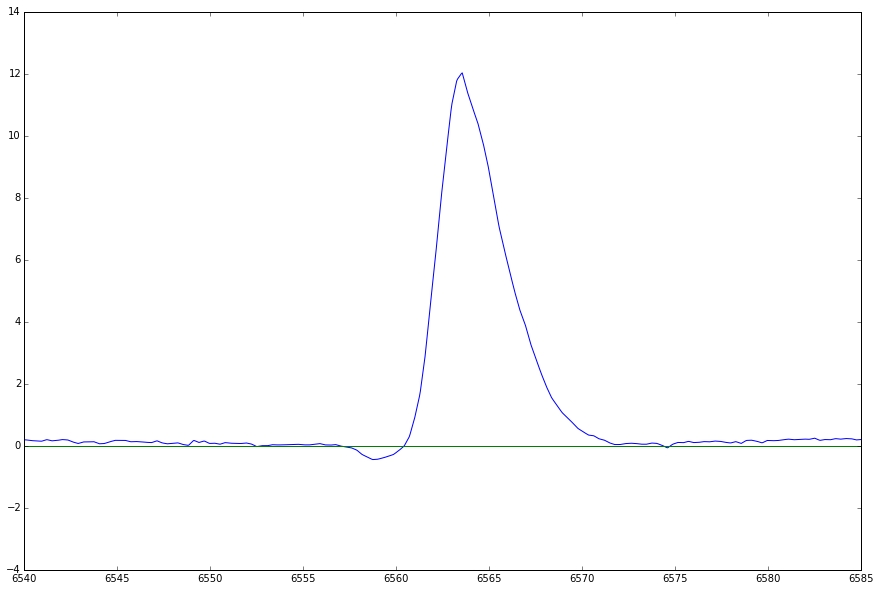

In [512]:
l=A[:,0]
x=A[:,1]
plt.figure(figsize=(15,10))
plt.plot(l,x-bbody(l,Teff,Aeff,Beff))
r=np.zeros(l.size)
plt.plot(l,r)
plt.xlim(6540,6585)

(-0.2, 1.1)

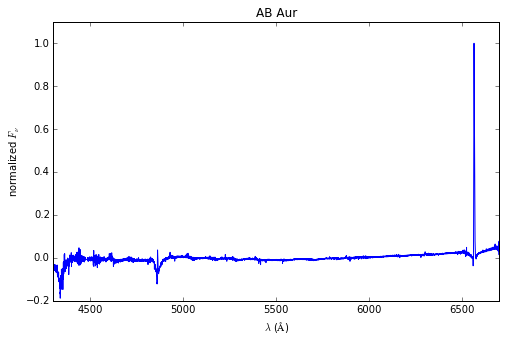

In [522]:
l=A[:,0]
x=A[:,1]
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4475
#lwfi=490
lwfi=4485
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=4744
#lwfi=490
lwfi=4746
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5111
#lwfi=490
lwfi=5112
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5460
#lwfi=490
lwfi=5462
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))
lwin=5482
#lwfi=490
lwfi=5484
x=np.concatenate((x[l<lwin],x[l>lwfi]))
l=np.concatenate((l[l<lwin],l[l>lwfi]))

plt.figure(figsize=(8,5))
plt.plot(l,(x-bbody(l,Teff,Aeff,Beff))/np.max(x-bbody(l,Teff,Aeff,Beff)))
plt.ylabel(r"normalized $F_\nu$")
plt.xlabel(r"$\lambda$ ($\AA$)")
plt.title("AB Aur")
plt.xlim(4300,6700)
plt.ylim(-0.2,1.1)

http://arxiv.org/pdf/astro-ph/0503507v2.pdf
http://www.star.ucl.ac.uk/~msw/thesis/chap6.pdf

In [402]:
def pcyg(l,mu1,sigma1,A1,mu2,sigma2,A2):
    gs1=A1*np.exp(-(l-mu1)**2/(2.*sigma1**2))
    gs2=-A2*np.exp(-(l-mu2)**2/(2.*sigma2**2))
    return gs1+gs2

[  8.54611754e-08  -1.60941881e-03   1.00818749e+01  -2.10029164e+04]


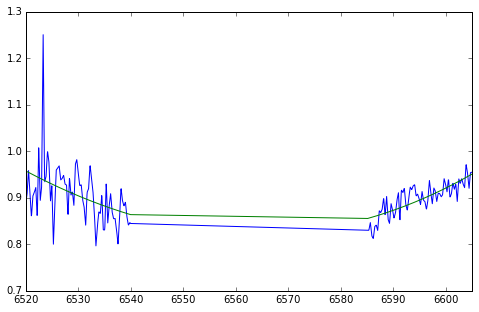

In [535]:
#6550-6575 es un ancho estándar para obtener el continuo
# da un mejor chi cuadrado que escogiendo un intervalo mas angosto para el continuo
l=A[:,0]
x=A[:,1]
lali=6540
lalf=6585
lin=6520
lfi=6605
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lali],x[l>lalf]))
l=np.concatenate((l[l<lali],l[l>lalf]))
contfit=np.polyfit(l,x,3)
plt.figure(figsize=(8,5))
plt.plot(l,x)
plt.plot(l,np.poly1d(contfit)(l))
plt.xlim(lin,lfi)
print contfit

[  6.56332441e+03   2.24809009e+00   1.20487909e+01   6.56090116e+03
   1.34968088e+00   6.19258139e+00]
Chi sq is 0.031070735637
Discrepancy 23


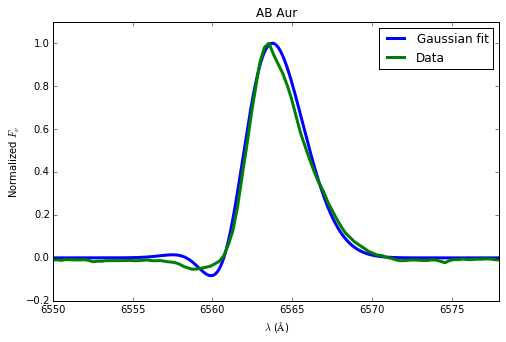

In [545]:
# este metodo da el menor chi2
l=A[:,0]
x=A[:,1]
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
xnorm=x-np.poly1d(contfit)(l)
par,pconv = curve_fit(pcyg, l, xnorm,p0=[6565.,2.,12.,6560.,1.,1.])
print par
plt.figure(figsize=(8,5))
plt.plot(l,pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5])/np.max(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5])),linewidth=3.,label="Gaussian fit")
plt.plot(l,xnorm/np.max(xnorm),linewidth=3.,label="Data")
delt=(xnorm-pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))**2
print "Chi sq is", delt.sum()/x.size
plt.xlim(lin,lfi)
plt.ylabel(r"Normalized $F_\nu$")
plt.xlabel(r"$\lambda$ ($\AA$)")
plt.title("AB Aur")
plt.ylim(-0.2,1.1)
print "Discrepancy",np.argmin(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))-np.argmin(xnorm)
plt.xlim(6550,6578)
plt.legend()

[  6.56332497e+03   2.26360139e+00   1.55860234e+01   6.56089880e+03
   1.34127630e+00   8.03377029e+00]
0.0626014898156
Discrepancy 23


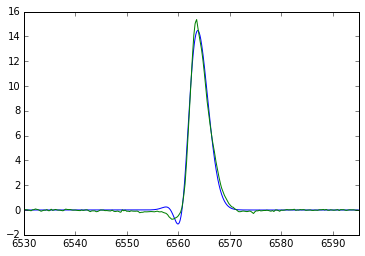

In [495]:
l=A[:,0]
x=A[:,1]
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
xnorm=x/np.poly1d(contfit)(l)-1
par,pconv = curve_fit(pcyg, l, xnorm,p0=[6565.,2.,12.,6560.,1.,1.])
print par
plt.plot(l,pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))
plt.plot(l,xnorm)
delt=(xnorm-pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))**2
print delt.sum()/x.size
plt.xlim(lin,lfi)
print "Discrepancy",np.argmin(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))-np.argmin(xnorm)

[  1.02556621e-06  -2.00563665e-02   1.30736654e+02  -2.84051791e+05]


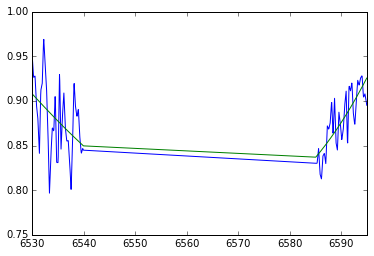

In [497]:
#esta ventana da un peor chi2
#6550-6575 es un ancho estándar para obtener el continuo
l=A[:,0]
x=A[:,1]
lali=6540
lalf=6585
lin=6530
lfi=6595
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
x=np.concatenate((x[l<lali],x[l>lalf]))
l=np.concatenate((l[l<lali],l[l>lalf]))
contfit=np.polyfit(l,x,3)
plt.plot(l,x)
plt.plot(l,np.poly1d(contfit)(l))
plt.xlim(lin,lfi)
print contfit

[  6.56332281e+03   2.26453919e+00   1.20683494e+01   6.56089635e+03
   1.34257084e+00   6.22640904e+00]
0.0379007949116
Discrepancy 23


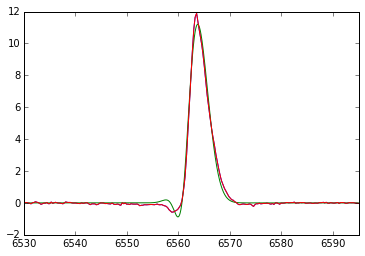

In [499]:
#norm- chi squared is lower than for norm/
l=A[:,0]
x=A[:,1]
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
xnorm=x-np.poly1d(contfit)(l)
plt.plot(l,xnorm)
plt.xlim(lin,lfi)
par,pconv = curve_fit(pcyg, l, xnorm,p0=[6565.,2.,12.,6560.,1.,1.])
print par
plt.plot(l,pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))
plt.plot(l,xnorm)
delt=(xnorm-pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))**2
print delt.sum()/x.size
print "Discrepancy",np.argmin(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))-np.argmin(xnorm)

[  6.56332497e+03   2.26360139e+00   1.55860234e+01   6.56089880e+03
   1.34127630e+00   8.03377029e+00]
0.0626014898156
Discrepancy 23


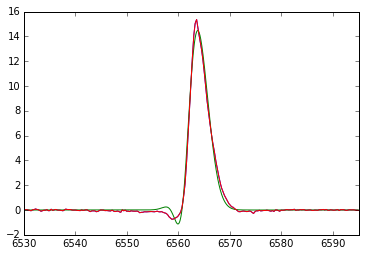

In [500]:
#norm/
l=A[:,0]
x=A[:,1]
x=x[l<lfi]
l=l[l<lfi]
x=x[l>lin]
l=l[l>lin]
xnorm=x/np.poly1d(contfit)(l)-1
plt.plot(l,xnorm)
plt.xlim(lin,lfi)
par,pconv = curve_fit(pcyg, l, xnorm,p0=[6565.,2.,12.,6560.,1.,1.])
print par
plt.plot(l,pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))
plt.plot(l,xnorm)
delt=(xnorm-pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))**2
print delt.sum()/x.size
print "Discrepancy",np.argmin(pcyg(l,par[0],par[1],par[2],par[3],par[4],par[5]))-np.argmin(xnorm)

In [450]:
def gau(l,mu1,sigma1,A1):
    gs1=A1*np.exp(-(l-mu1)**2/(2.*sigma1**2))
    return gs1